In [1]:
from ensembles import VanillaEnsemble, BootstrapEnsemble
from datasets import make_dataset, make_cross_validation_dataset
from plot import plot_dataset, plot_prediction
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 4]
from evaluation import evaluate_model
import tensorflow as tf

# Explanation



Showing the efficiency of two types of ensembles, Vanilla Network Ensemble with different initialisation parameters and Bootstrap Ensemble grown by presenting copies of the exact same model with different subsets of the dataset.

All underlying Estimators are built in tensorflow (1.4) and are based on the same parent object (ToDo: Make this more beautiful and readable). Can be found in /estimators. The Ensembles simulate Online Training rather than actually training online at the moment (ToDo: Rewrite Ensembles to train online properly). The Code can be found in /ensembles.

VanillaEnsemble, which is an ensemble of the class EnsembleNetwork that differ in two significant ways: 
    1. different number of layers 
    2. different initial conditions (translates to different seeds at weight initialisation time)
    3. each of the networks are shown the full dataset
Inspired by an approach used in [1]

    
   
BootstrapEnsemble, which is an ensemble of the class EnsembleNetwork in which each part of the ensemble:
    1. share the exact same hyperparameters
    2. share the same initial conditions (translates to setting the same seed at weight initialisation time)
    3. are each shown  ~ 50% of the Dataset
Expansion of [2] to (kind of) work with Deep Networks 


No Regularisation has been added, thus quite a bit of overfitting occurs.

ToDo:

- add Dropout Ensemble from [3]





# Parameters
parameters have been chosen at 'random', i.e. not much thought has been put into them. No Gridsearch for optimal parameter spaces or similar.

each neural network is contains three hidden layers with 10 neurons each, the learning rate has been set to 0.001 which seems a literature standard (cite needed)

The layers are instantiated by draws from a normal distribution (0,1), for the Bootstrap network a distribution over parameters can be achieved by assuming that each $w_i$ is a draw from a normal distribution. While thinkable in theory, the same is non-trivial for an ensemble with differing hyperparameters (i.e. different number of layers and different layer sizes).

# Dataset 
The Dataset contains 100 samples generated by the function 

$5 \cdot sin(X) + 10 + X^2 + noise$

where X is linearly spaced patches in the intervall [-5,5] the noise is drawn from a normal distribution (0,4)

# Training
Each network is trained on 10 * 100 = 1000 epochs

Training is offline. The datasets are shown to the estimators as a whole (although it should be relatively easy to switch to online) (ToDo: Switch to Online). The Bootstrap in the Bootstrap Estimator is achieved by randomly drawing  sub-datasets that each contain ~ 50% of datapoints.
The optimizer is the standard implementation of tensorflow's tf.train.GradientDescentOptimizer 


# Evaluation
Right now, the RSME and the coverage probability of the prediction is reported, where the data is available (i.e. VanillaNetwork does not return uncertainty = no Coverage). At the moment, evaluation happens on the training set (because the data generating model is a bit annoying to work with because of quite frankly a bit of a stupid shuffling situation, which is on the ToDo list) (ToDo: solve that)

# Problems/ToDo

It's not entirely clear (ToDo: Literature search) what scaling factor should be used for the variance. While the VanillaEnsemble can to a certain extend be influenced by choosing vastly different models (including untouched hyperparameters such as but not limited to _weight initialisation schemes, optimisation algorithms, learning rate,..._, it's not entirely obvious which hyperparameters apart from the number of estimators $p_{keep}$ that regulates the size of the subsampled datasets can be chosen to generate inherently greater (or lower) variance in the samples.

Hyperparameters need to be tuned

No real Online Training

Evaluation on training set (alas only to make a point about uncertainty so maybe can be forgiven in this phase)




[1] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. In Advances in Neural Information Processing Systems (pp. 6405-6416).
Chicago	

Link: https://arxiv.org/abs/1612.01474



[2] Eckles, D., & Kaptein, M. (2014). Thompson sampling with the online bootstrap. arXiv preprint arXiv:1410.4009.

Link: https://arxiv.org/abs/1410.4009


[3] Gal, Y., & Ghahramani, Z. (2016, June). Dropout as a Bayesian approximation: Representing model uncertainty in deep learning. In international conference on machine learning (pp. 1050-1059).

Link: http://proceedings.mlr.press/v48/gal16.html

# Preparations

In [2]:
data = make_dataset(train_p=0.8)

X = data['X']
y = data['y']
X_test = data['X_test']
y_test = data['y_test']
generate_sinoid = data['generating']
#sorted_index = data['train_index']
sorted_index = data['shuffle_index']
#test_index = data['test_ind']

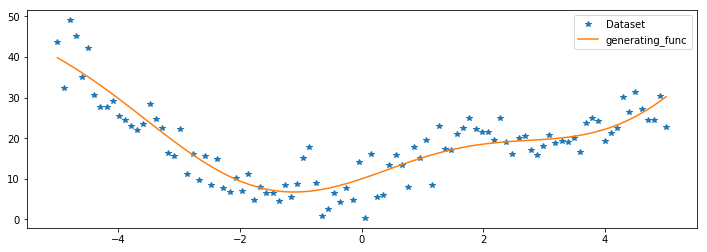

In [3]:
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Initialise Ensembles

In [4]:
num_epochs = 10
num_eps = 100
#ensemble = [{'num_neurons':[10,10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
#            {'num_neurons':[10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
#            {'num_neurons':[10,10,10,10,10,10],'num_epochs':num_epochs}]#,'optimizer':tf.train.AdamOptimizer}]
        

ensemble = [{'num_neurons':[10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,5,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,5,20],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,5],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10],'num_epochs':num_epochs}]#,'optimizer':tf.train.AdamOptimizer}]
        
    
    
vanilla = VanillaEnsemble(estimator_stats = ensemble)


#bootstrap_ensemble = {'num_neurons':[10,10,10,10,10],'num_epochs':num_epochs}#,'optimizer':tf.train.AdamOptimizer}
bootstrap_ensemble = {'num_neurons':[10,10,10],'num_epochs':num_epochs}#,'optimizer':tf.train.AdamOptimizer}

bootstrap = BootstrapEnsemble(estimator_stats= bootstrap_ensemble)

In [5]:
def get_mean_var(pred_dict):
    return pred_dict['means'],pred_dict['stds']
    

Vanilla Ensemble already displays a measure of uncertainty due to the ensembled models being initialised differently.
Bootstrap Ensemble does not have uncertainty die to the fact that all contained models are initialised in exactly the same way (thus each sample returns the exact same values)

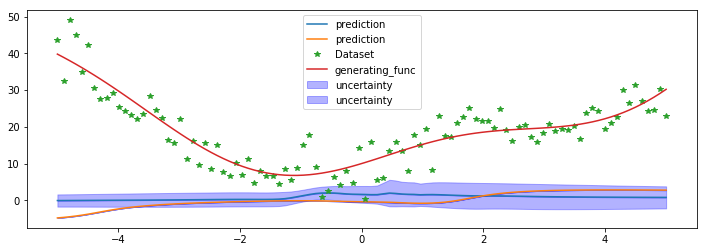

In [6]:
vanilla_pred_dict = vanilla.predict(X)
vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
bootstrap_pred_dict = bootstrap.predict(X)
bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_dict)
plot_prediction(X,
                vanilla_preds,
                sorted_index,
                vanilla_var)

plot_prediction(X,
                bootstrap_preds,
                sorted_index,
                bootstrap_var)

plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Training

## Vanilla Ensemble

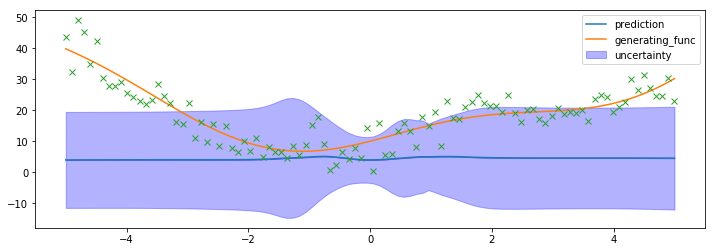

RSME is 16.964169162786842
COVERAGE PROBABILITY is 0.56
MEAN VARIANCE is 14.947461128234863
COVERAGE/MEAN_VAR is 0.03746455636818439


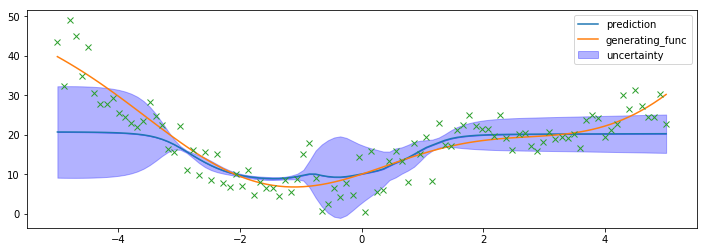

RSME is 6.85555732472239
COVERAGE PROBABILITY is 0.54
MEAN VARIANCE is 4.704485893249512
COVERAGE/MEAN_VAR is 0.11478406190458526


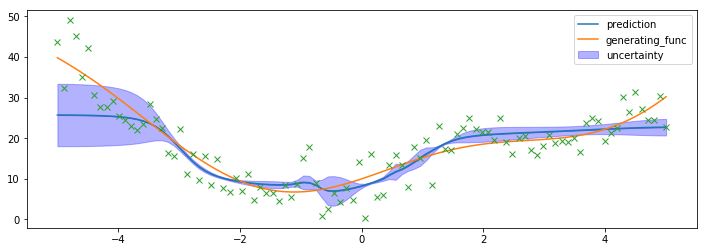

RSME is 5.445448029721082
COVERAGE PROBABILITY is 0.32
MEAN VARIANCE is 2.156585216522217
COVERAGE/MEAN_VAR is 0.14838272911656278


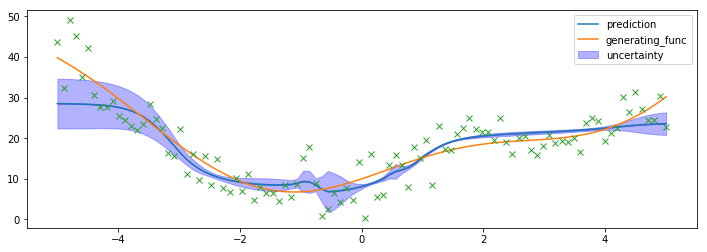

RSME is 4.918904673217525
COVERAGE PROBABILITY is 0.26
MEAN VARIANCE is 1.8181780576705933
COVERAGE/MEAN_VAR is 0.14300029576481957


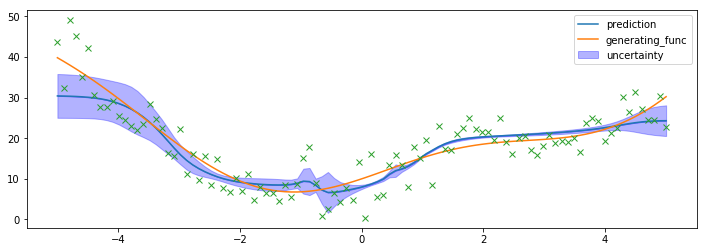

RSME is 4.604463803206752
COVERAGE PROBABILITY is 0.29
MEAN VARIANCE is 1.886540412902832
COVERAGE/MEAN_VAR is 0.15372053416750034


In [7]:
vanilla_error_list = []
for i in range(num_eps):
    vanilla.train(X,y)
    #errors = vanilla.train_and_evaluate(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #vanilla_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        vanilla_pred_dict = vanilla.predict(X)
        vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
        vanilla_var = vanilla_var**2
        plot_prediction(X,vanilla_preds,sorted_index,vanilla_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,vanilla_preds,var=vanilla_var)

In [8]:
#plt.plot(np.squeeze(vanilla_error_list))

## Bootstrap Ensemble

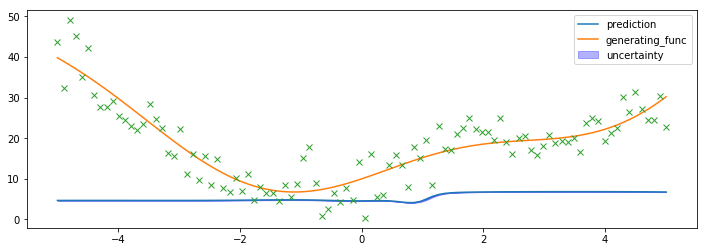

RSME is 15.927050709981051
COVERAGE PROBABILITY is 0.01
MEAN VARIANCE is 0.05315385386347771
COVERAGE/MEAN_VAR is 0.18813311308873978


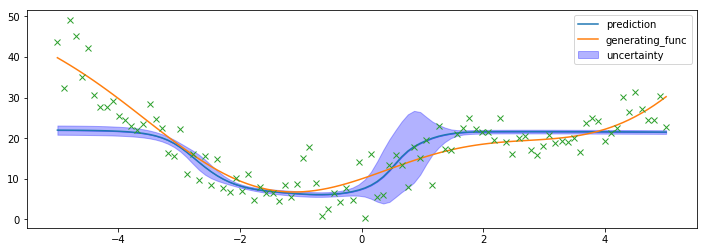

RSME is 6.468406967223038
COVERAGE PROBABILITY is 0.18
MEAN VARIANCE is 1.4453785419464111
COVERAGE/MEAN_VAR is 0.12453485005914366


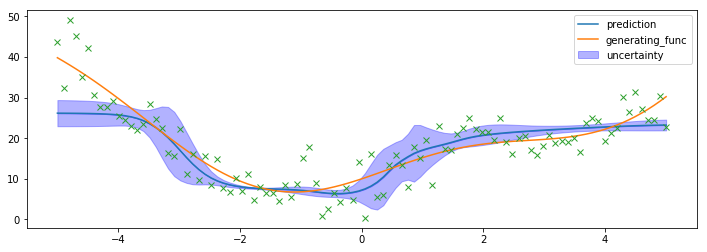

RSME is 5.406263170004813
COVERAGE PROBABILITY is 0.34
MEAN VARIANCE is 2.439777135848999
COVERAGE/MEAN_VAR is 0.1393569908514148


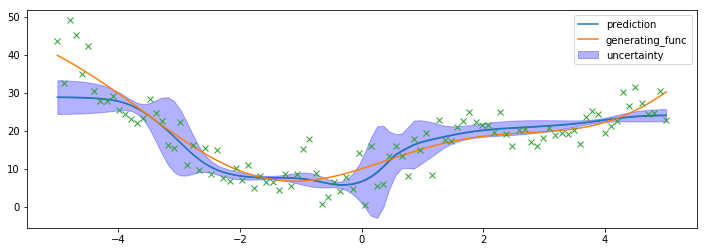

RSME is 4.898770271238029
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 2.8234071731567383
COVERAGE/MEAN_VAR is 0.15229826009092207


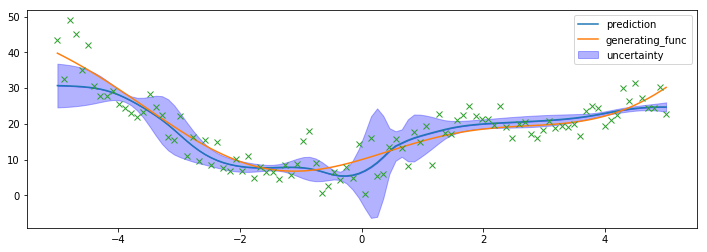

RSME is 4.5886700585991145
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 3.0155251026153564
COVERAGE/MEAN_VAR is 0.142595397274943


In [9]:
gauss_error_list = []
for i in range(num_eps):
    bootstrap.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = bootstrap.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2
        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

# Old Stuff, can probably be deleted, kept for security reasons

In [10]:
vanilla.train(X,y)
bootstrap.train(X,y)

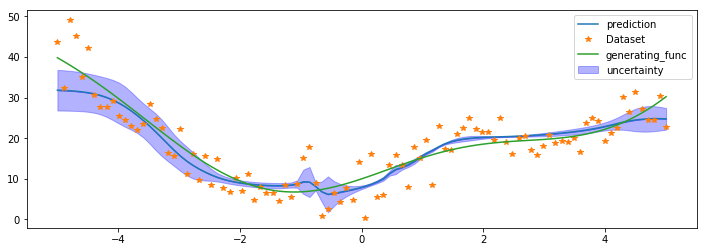

In [11]:
vanilla_pred_dict = vanilla.predict(X)
vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
bootstrap_pred_dict = bootstrap.predict(X)
bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_dict)
plot_prediction(X,
                vanilla_preds,
                sorted_index,
                vanilla_var**2)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

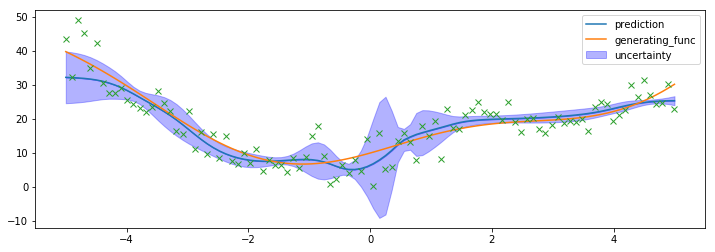

RSME is 4.369844497719975
COVERAGE PROBABILITY is 0.47
MEAN VARIANCE is 3.3282861709594727
COVERAGE/MEAN_VAR is 0.14121381872175648


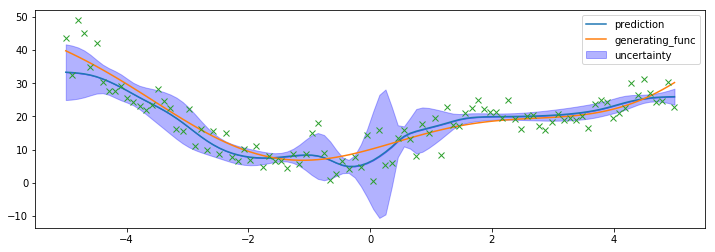

RSME is 4.21838149754329
COVERAGE PROBABILITY is 0.62
MEAN VARIANCE is 3.8845725059509277
COVERAGE/MEAN_VAR is 0.15960572213549828


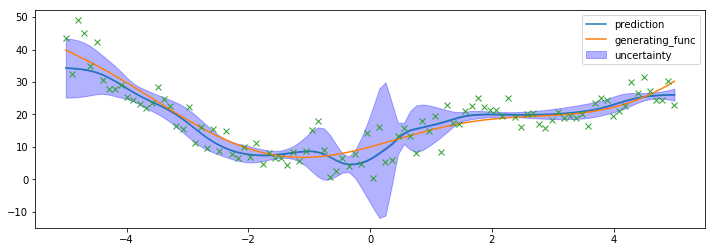

RSME is 4.09311520856785
COVERAGE PROBABILITY is 0.57
MEAN VARIANCE is 3.8955342769622803
COVERAGE/MEAN_VAR is 0.14632139251627466


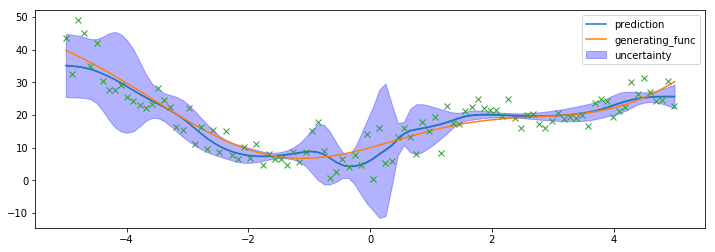

RSME is 4.025625310260696
COVERAGE PROBABILITY is 0.66
MEAN VARIANCE is 4.996396541595459
COVERAGE/MEAN_VAR is 0.13209519991166424


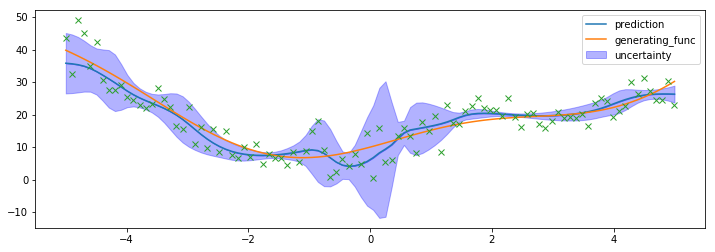

RSME is 3.9175128037412548
COVERAGE PROBABILITY is 0.64
MEAN VARIANCE is 4.518751621246338
COVERAGE/MEAN_VAR is 0.14163203770502408


In [12]:
#gauss_error_list = []
for i in range(num_eps):
    bootstrap.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = bootstrap.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [13]:
evaluate_model(X,y,vanilla_preds,var=vanilla_var**2)

RSME is 4.381888945050098
COVERAGE PROBABILITY is 0.33
MEAN VARIANCE is 1.8447144031524658
COVERAGE/MEAN_VAR is 0.17888947982194808


In [14]:
evaluate_model(X,y,bootstrap_preds,var=bootstrap_var**2)

RSME is 3.9175128037412548
COVERAGE PROBABILITY is 0.83
MEAN VARIANCE is 35.945106506347656
COVERAGE/MEAN_VAR is 0.023090764798636157


# Hic sunt dracones

In [15]:
from ensembles import GaussianNetworkEnsemble, GaussianLRNetworkEnsemble


In [16]:
gauss = GaussianNetworkEnsemble(estimator_stats = ensemble)

In [17]:
gauss_dict = gauss.predict(X)

In [18]:
mean,std = get_mean_var(gauss_dict)

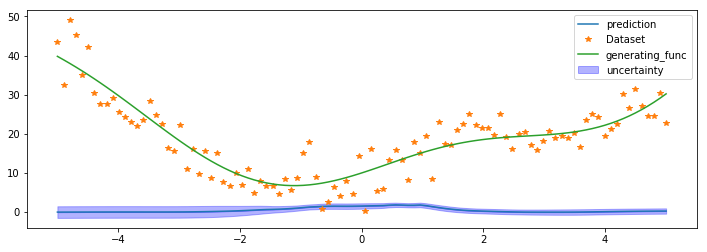

In [19]:
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

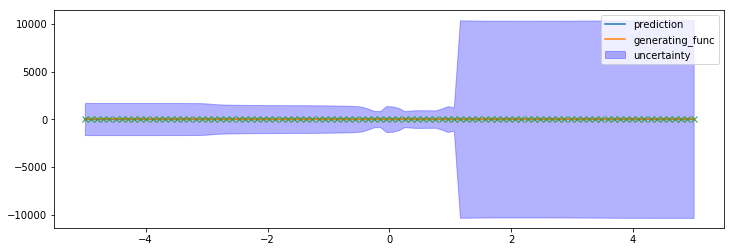

RSME is 9.8270438215305
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 4906.6162109375
COVERAGE/MEAN_VAR is 0.0002038064435875109


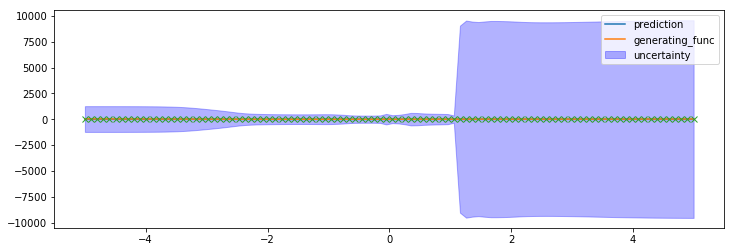

RSME is 6.9206108576648155
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 4137.7001953125
COVERAGE/MEAN_VAR is 0.0002416801490675607


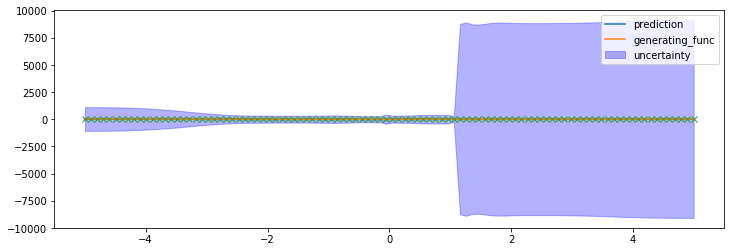

RSME is 5.6179015298417365
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 3806.899658203125
COVERAGE/MEAN_VAR is 0.00026268094506909194


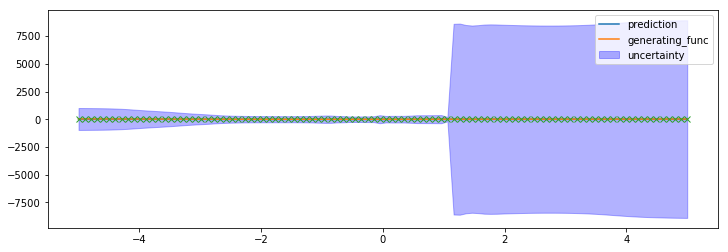

RSME is 5.017636393436956
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 3643.05224609375
COVERAGE/MEAN_VAR is 0.000274495102581152


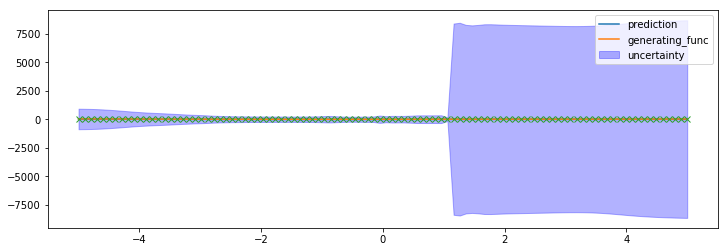

RSME is 4.723523235277574
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 3499.640869140625
COVERAGE/MEAN_VAR is 0.000285743605527604


In [27]:
#gauss_error_list = []
for i in range(num_eps):
    gauss.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = gauss.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [20]:
gauss.train(X,y)

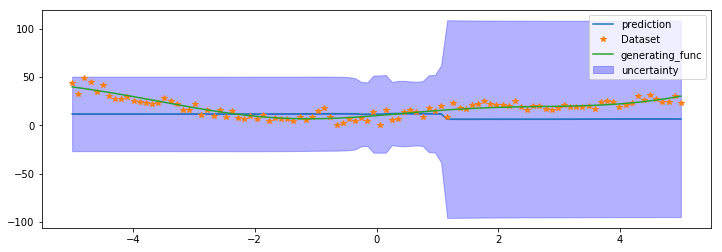

In [21]:
gauss_dict = gauss.predict(X)
mean,std = get_mean_var(gauss_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Learning Rate stuff


In [22]:
gauss_lr = GaussianLRNetworkEnsemble(estimator_stats = ensemble)

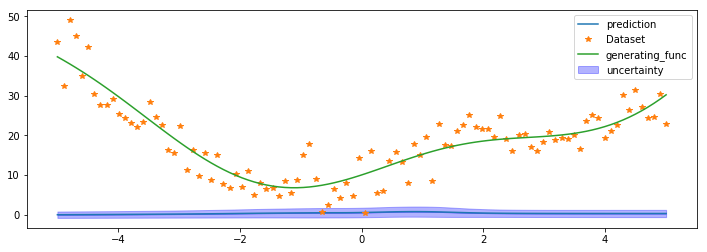

In [23]:
gauss_lr_dict = gauss_lr.predict(X)
mean,std = get_mean_var(gauss_lr_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

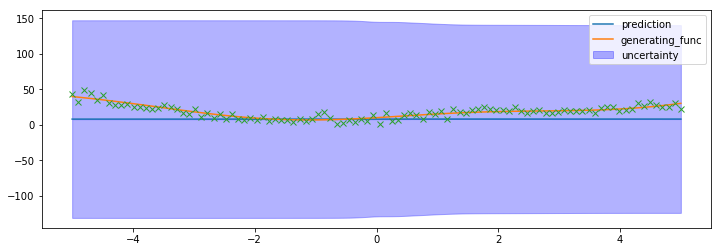

RSME is 14.097251648650916
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 136.4173583984375
COVERAGE/MEAN_VAR is 0.007330445419411184


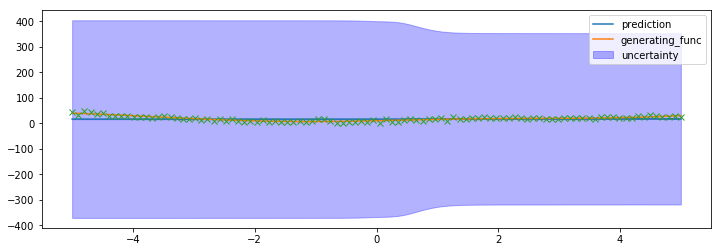

RSME is 9.611098303614522
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 364.931396484375
COVERAGE/MEAN_VAR is 0.0027402410689616186


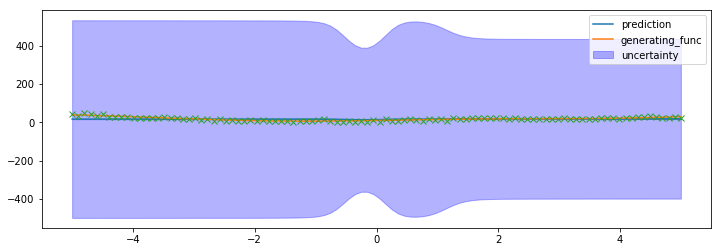

RSME is 9.19838661272173
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 467.3258056640625
COVERAGE/MEAN_VAR is 0.0021398347531419028


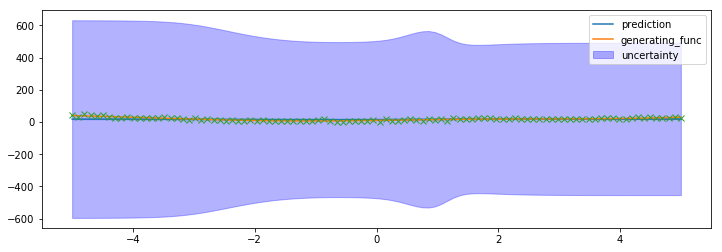

RSME is 8.677171127003444
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 516.6163940429688
COVERAGE/MEAN_VAR is 0.0019356722154597876


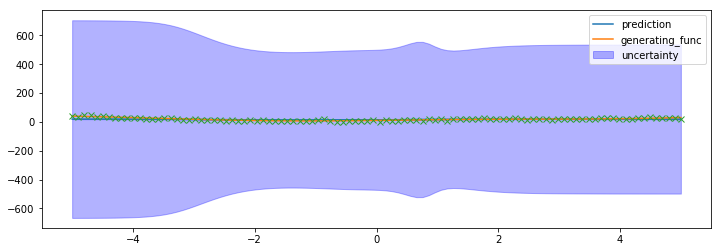

RSME is 8.070496229946368
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 537.78759765625
COVERAGE/MEAN_VAR is 0.0018594701781114574


In [28]:
#gauss_error_list = []
for i in range(num_eps):
    gauss_lr.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = gauss_lr.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [24]:
gauss_lr.train(X,y)

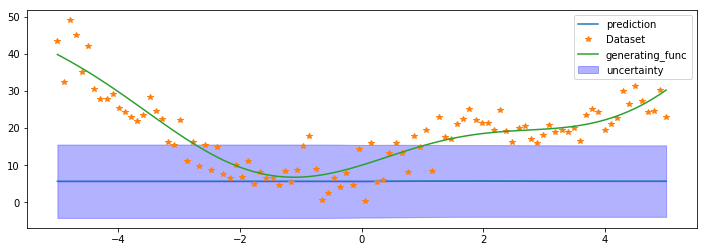

In [25]:
gauss_lr_dict = gauss_lr.predict(X)
mean,std = get_mean_var(gauss_lr_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)